<a href="https://colab.research.google.com/github/varunchandra10/datamining_algorithms/blob/main/Classification/Naive_Bayes_classifier/Bayes_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic EDA for playing_tennis_dataset

In [37]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
path = "/content/sample_data/playing_tennis_dataset.csv"
df = pd.read_csv(path)

In [68]:
# Load dataset and get features
def load_dataset(df, target_column=None):
    if not target_column:
        print("\nColumns in the dataset:", list(df.columns))
        target_column = input("Please enter the target column name (class column): ").strip()

    if target_column not in df.columns:
        raise ValueError(f"'{target_column}' not found in dataset columns.")

    features = [col for col in df.columns if col != target_column]
    return df, features, target_column

In [69]:
df, features, target_column = load_dataset(df, target_column="PlayTennis")

In [24]:
df.head()

,Outlook,Temperature,Humidity,Wind,PlayTennis
0,Rain,Hot,High,Strong,Yes
1,Sunny,Mild,Normal,Strong,No
2,Sunny,Mild,High,Strong,Yes
3,Rain,Cool,High,Weak,Yes
4,Overcast,Mild,High,Weak,No


In [27]:
df.shape

(150, 5)

In [28]:
df.isnull().sum()

,0
Outlook,0
Temperature,0
Humidity,0
Wind,0
PlayTennis,0


In [70]:
print("\n3. Summary of Categorical Variables:")
for feature in features:
    print(df[feature].value_counts())

print(f"\nClass Distribution:")
print(df[target_column].value_counts())


3. Summary of Categorical Variables:
Outlook
Sunny       55
Rain        52
Overcast    43
Name: count, dtype: int64
Temperature
Hot     56
Cool    51
Mild    43
Name: count, dtype: int64
Humidity
High      84
Normal    66
Name: count, dtype: int64
Wind
Strong    86
Weak      64
Name: count, dtype: int64

Class Distribution:
PlayTennis
No     82
Yes    68
Name: count, dtype: int64


ValueError: num must be an integer with 1 <= num <= 4, not 5

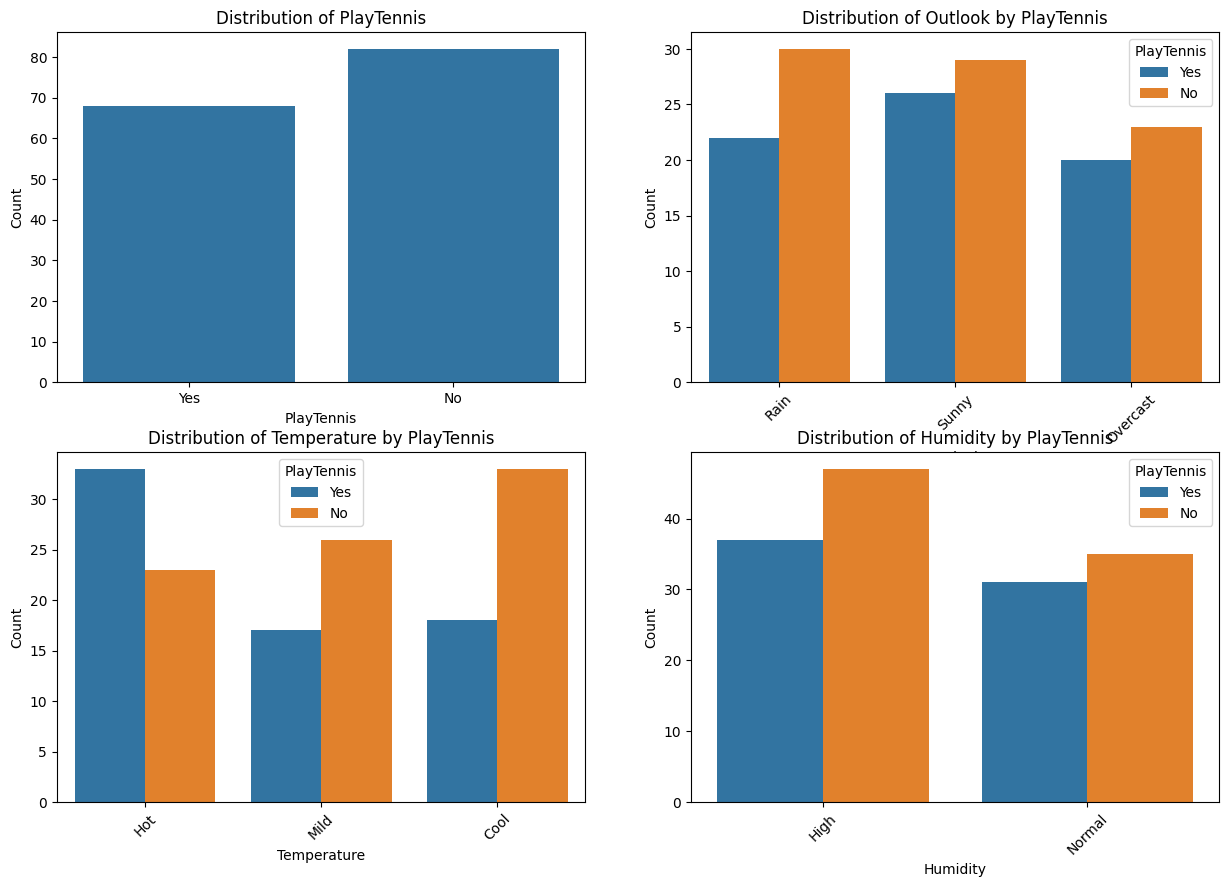

In [71]:
# Visualizations
plt.figure(figsize=(15, 10))

# Class distribution
plt.subplot(2, 2, 1)
sns.countplot(x=target_column, data=df)
plt.title(f'Distribution of {target_column}')
plt.xlabel(target_column)
plt.ylabel('Count')

# Feature distributions
for i, feature in enumerate(features, 2):
    plt.subplot(2, 2, i)
    sns.countplot(x=feature, data=df, hue=target_column)
    plt.title(f'Distribution of {feature} by {target_column}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [43]:
print("\n4. Contingency Tables:")
for feature in features:
    contingency_table = pd.crosstab(df[feature], df[target_column], margins=True, margins_name="Total")
    print(f"\nContingency Table: {feature} vs {target_column}")
    print(contingency_table.to_string())


4. Contingency Tables:

Contingency Table: Outlook vs PlayTennis
PlayTennis  No  Yes  Total
Outlook                   
Overcast    23   20     43
Rain        30   22     52
Sunny       29   26     55
Total       82   68    150

Contingency Table: Temperature vs PlayTennis
PlayTennis   No  Yes  Total
Temperature                
Cool         33   18     51
Hot          23   33     56
Mild         26   17     43
Total        82   68    150

Contingency Table: Humidity vs PlayTennis
PlayTennis  No  Yes  Total
Humidity                  
High        47   37     84
Normal      35   31     66
Total       82   68    150

Contingency Table: Wind vs PlayTennis
PlayTennis  No  Yes  Total
Wind                      
Strong      43   43     86
Weak        39   25     64
Total       82   68    150


# Navies Bayes classifier without library

In [78]:
def compute_frequency_tables(df, feature_cols, target_col):
    freq_tables = {}
    class_labels = sorted(df[target_col].unique())

    for feature in feature_cols:
        table = defaultdict(lambda: defaultdict(int))
        for _, row in df.iterrows():
            val = row[feature]
            label = row[target_col]
            table[label][val] += 1

        unique_vals = sorted(df[feature].unique())
        freq_df = pd.DataFrame({val: [table[label][val] for label in class_labels]
                                for val in unique_vals}, index=class_labels)
        freq_tables[feature] = freq_df

    return freq_tables, class_labels

In [79]:
def compute_likelihood_tables(freq_tables, df, feature_cols, target_col, class_labels):
    class_counts = df[target_col].value_counts().to_dict()
    total_samples = len(df)

    priors = {label: class_counts[label] / total_samples for label in class_labels}
    likelihood_tables = {}

    for feature in feature_cols:
        unique_vals = sorted(df[feature].unique())
        table = defaultdict(lambda: defaultdict(float))

        for label in class_labels:
            total_class_count = class_counts[label]
            for val in unique_vals:
                count = freq_tables[feature].loc[label, val]
                table[label][val] = (count + 1) / (total_class_count + len(unique_vals))  # Laplace smoothing

        likelihood_df = pd.DataFrame({val: [table[label][val] for label in class_labels]
                                      for val in unique_vals}, index=class_labels)
        likelihood_tables[feature] = likelihood_df

    return priors, likelihood_tables, class_counts

In [86]:
def compute_priors(df, target_col):
    class_counts = df[target_col].value_counts().to_dict()
    total_samples = len(df)
    priors = {label: class_counts[label] / total_samples for label in class_counts}
    return priors, class_counts

def display_priors(priors):
    print("\n=== Prior Probabilities ===")
    for label, prob in priors.items():
        print(f"P({label}) = {prob:.4f}")

In [81]:
def predict_single_instance(test_instance, priors, likelihood_tables, feature_cols, class_labels, class_counts):
    test_likelihoods = defaultdict(lambda: defaultdict(float))
    scores = {}

    for label in class_labels:
        for feature in feature_cols:
            value = test_instance[feature]
            if value in likelihood_tables[feature].columns:
                test_likelihoods[label][feature] = likelihood_tables[feature].loc[label, value]
            else:
                # Handle unseen values using Laplace smoothing
                total_class_count = class_counts[label]
                unique_vals_count = len(likelihood_tables[feature].columns)
                test_likelihoods[label][feature] = 1 / (total_class_count + unique_vals_count)

    print(f"\n--- Likelihoods for Test Sample: {test_instance.to_dict()} ---")
    for label in class_labels:
        print(f"\nClass: {label}")
        for feature in feature_cols:
            print(f"P({feature}={test_instance[feature]} | {label}) = {test_likelihoods[label][feature]:.4f}")

    for label in class_labels:
        likelihood_product = np.prod(list(test_likelihoods[label].values()))
        scores[label] = priors[label] * likelihood_product

    print("\nPosterior Probabilities:")
    for label in class_labels:
        print(f"P({label} | features) ∝ {scores[label]:.8f}")

    prediction = max(scores, key=scores.get)
    print(f"\n🎯 Final Prediction: {prediction}")
    return prediction

In [82]:
def predict(test_df, priors, likelihood_tables, feature_cols, class_labels, class_counts):
    predictions = []
    for idx, row in test_df.iterrows():
        print(f"\n========= Test Sample {idx + 1} =========")
        prediction = predict_single_instance(row, priors, likelihood_tables, feature_cols, class_labels, class_counts)
        predictions.append(prediction)
    return predictions

In [88]:
# Now compute everything and predict
freq_tables, class_labels = compute_frequency_tables(df, features, target_column)
priors, likelihood_tables, class_counts = compute_likelihood_tables(freq_tables, df, features, target_column, class_labels)

# Show Training Outputs
priors, class_counts = compute_priors(df, target_column)
# Show Training Outputs
display_priors(priors)


=== Prior Probabilities ===
P(No) = 0.5467
P(Yes) = 0.4533


In [89]:
test_data = [
    {'Outlook': 'Sunny', 'Temperature': 'Cool', 'Humidity': 'High', 'Wind': 'Strong'},
    {'Outlook': 'Overcast', 'Temperature': 'Mild', 'Humidity': 'High', 'Wind': 'Weak'}
]
df_test = pd.DataFrame(test_data)

# Run predictions
predictions = predict(df_test, priors, likelihood_tables, features, class_labels, class_counts)


========= Test Sample 1 =========

--- Likelihoods for Test Sample: {'Outlook': 'Sunny', 'Temperature': 'Cool', 'Humidity': 'High', 'Wind': 'Strong'} ---

Class: No
P(Outlook=Sunny | No) = 0.3529
P(Temperature=Cool | No) = 0.4000
P(Humidity=High | No) = 0.5714
P(Wind=Strong | No) = 0.5238

Class: Yes
P(Outlook=Sunny | Yes) = 0.3803
P(Temperature=Cool | Yes) = 0.2676
P(Humidity=High | Yes) = 0.5429
P(Wind=Strong | Yes) = 0.6286

Posterior Probabilities:
P(No | features) ∝ 0.02310044
P(Yes | features) ∝ 0.01574195

🎯 Final Prediction: No

========= Test Sample 2 =========

--- Likelihoods for Test Sample: {'Outlook': 'Overcast', 'Temperature': 'Mild', 'Humidity': 'High', 'Wind': 'Weak'} ---

Class: No
P(Outlook=Overcast | No) = 0.2824
P(Temperature=Mild | No) = 0.3176
P(Humidity=High | No) = 0.5714
P(Wind=Weak | No) = 0.4762

Class: Yes
P(Outlook=Overcast | Yes) = 0.2958
P(Temperature=Mild | Yes) = 0.2535
P(Humidity=High | Yes) = 0.5429
P(Wind=Weak | Yes) = 0.3714

Posterior Probabiliti

# Using libraries

In [111]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

data = pd.read_csv('/content/sample_data/playing_tennis_dataset.csv')

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

feature_encoder = OrdinalEncoder()
X_encoded = feature_encoder.fit_transform(X)

target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

# Train Naive Bayes model
model = CategoricalNB()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

sample_input = pd.DataFrame([['Sunny', 'Mild', 'High', 'Weak']], columns=X.columns)

sample_input_encoded = feature_encoder.transform(sample_input)

# Predict class
prediction = model.predict(sample_input_encoded)
predicted_class = target_encoder.inverse_transform(prediction)
print("\nPredicted class for new input:", predicted_class[0])


Accuracy: 0.6666666666666666
F1 Score: 0.6243386243386244

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.94      0.76        17
           1       0.80      0.31      0.44        13

    accuracy                           0.67        30
   macro avg       0.72      0.62      0.60        30
weighted avg       0.71      0.67      0.62        30


Predicted class for new input: No
